# E91 Quanten-Schlüsselaustausch mit Qiskit

In diesem Notebook demonstrieren wir das **E91-Protokoll** nach Ekert (1991), indem wir **Qiskit** verwenden, um:
1. Einen **Singulett-Zustand** (Bell-Zustand) zu erzeugen,
2. Diesen in verschiedenen Basen zu **messen**,
3. Die **CHSH-Korrelation** (zur Eavesdropping-Erkennung) zu bestimmen,
4. Und mit **Bloch-Kugel-Darstellungen** anschaulich zu machen, wie die Zustände aussehen.

## Inhalt
1. [Einleitung zum E91-Protokoll](#einleitung)
2. [Vorbereitung: Importe und Simulator](#vorbereitung)
3. [Erzeugung des Singulett-Zustands](#singulett)
4. [Bloch-Kugel-Visualisierungen](#bloch)
5. [Messungen in verschiedenen Basen & CHSH-Test](#chsh)
6. [E91-Schlüsselerzeugung (Kurzfassung)](#schluessel)
7. [Fazit zum E91](#fazit)


<a id="einleitung"></a>
## 1. Einleitung zum E91-Protokoll

Das **E91-Protokoll** wurde 1991 von Artur Ekert vorgeschlagen und beruht auf der Verschränkung zweier Qubits (Bell-Paar). Eine vertrauenswürdige (oder beliebige) Quelle erzeugt diese verschränkten Paare. Anschließend erhält Alice das eine Qubit, Bob das andere. Um die Sicherheit zu gewährleisten, messen Alice und Bob ihre Qubits in mehreren verschiedenen Basen und überprüfen die **CHSH-Ungleichung**. Liegt der gemessene CHSH-Parameter \(|S|\) über 2, zeigt dies auf **nicht-lokale Korrelationen** hin, wie man sie nur bei echter Verschränkung erwarten würde. Ein Lauscher (Eve) würde diese Korrelationen merklich stören.

Aus den Messungen in **kompatiblen Basen** können Alice und Bob anschließend den geheimen Schlüssel extrahieren, sofern sie feststellen, dass kein signifikantes Abhören stattfand.


<a id="vorbereitung"></a>
## 2. Vorbereitungen: Importe und Simulator

Wir verwenden hier den **AerSimulator** aus `qiskit_aer`. Zudem laden wir Visualisierungstools wie `plot_bloch_multivector` und `plot_histogram`. Das `%matplotlib inline`-Magic-Befehl sorgt dafür, dass unsere Plots direkt im Notebook erscheinen.
Zusätzliche Pakete können je nach Bedarf installiert oder importiert werden (z.B. `qiskit.tools.jupyter`).

In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Statevector
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector, plot_histogram

%matplotlib inline

# Unser QASM- und Statevector-Simulator
simulator = AerSimulator()
print("Qiskit- und Matplotlib-Umgebung bereit!")

Qiskit- und Matplotlib-Umgebung bereit!


Die folgende Funktion `correlation` wird später gebraucht, um aus **Zählstatistiken** (gemessenen Counts) Korrelationen zu berechnen. Das hilft uns insbesondere bei der Auswertung des CHSH-Parameters.

In [2]:
def correlation(counts):
    """
    Erwartungswert E = ( (#00 + #11) - (#01 + #10)) / (Summe aller counts)
    Interpretation:
    - Qubit 0 -> Bit a
    - Qubit 1 -> Bit b
    - 0 => +1, 1 => -1
    """
    shots = sum(counts.values())
    c00 = counts.get('00', 0)
    c11 = counts.get('11', 0)
    c01 = counts.get('01', 0)
    c10 = counts.get('10', 0)
    return ((c00 + c11) - (c01 + c10)) / shots

<a id="singulett"></a>
## 3. Erzeugung des Singulett-Zustands

Der **Singulett-Zustand** (\(|\psi^-\rangle\)) gehört zu den vier Bell-Zuständen und kann (bis auf globale Phasen) wie folgt geschrieben werden:
\[
    |\psi^-\rangle = \frac{1}{\sqrt{2}} (|01\rangle - |10\rangle).
\]
Um ihn in Qiskit zu erzeugen, genügt meist eine kurze Sequenz von Gattern:
1. Wir wandeln das zweite Qubit (Index 1) in den Zustand \(|1\rangle\) per X-Gatter.
2. Wir legen am ersten Qubit (Index 0) ein Hadamard an.
3. Wir führen ein CNOT(0->1) aus.
4. Wir legen eine Z-Operation auf das zweite Qubit an (um die relative Phase herzustellen).

Damit wird der Zustand (|01> - |10>)/sqrt(2) realisiert.


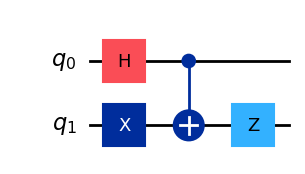

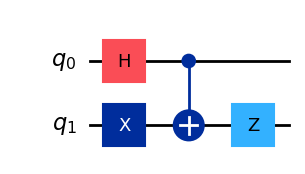

In [3]:
def create_singlet_circuit():
    qc = QuantumCircuit(2, name="Singulett")
    # 1) X(1) => |01>
    qc.x(1)
    # 2) H(0)
    qc.h(0)
    # 3) CNOT(0->1)
    qc.cx(0, 1)
    # 4) Z(1)
    qc.z(1)
    return qc

# Erzeuge den Schaltkreis und zeige den Statevector
qc_singlet = create_singlet_circuit()
qc_singlet.draw('mpl')

Wir lassen uns nun den resultierenden **Statevector** anzeigen. Er sollte (bis auf Phasen) dem \((|01\rangle - |10\rangle)/\sqrt{2}\) entsprechen.

In [4]:
transpiled_singlet = transpile(qc_singlet, simulator)
job_sv = simulator.run(transpiled_singlet)
sv_result = job_sv.result()
psi_state = Statevector.from_instruction(qc_singlet)
print("Singulett-Zustand (amplitudenweise):", psi_state)

Singulett-Zustand (amplitudenweise): Statevector([ 0.        +0.j,  0.70710678+0.j, -0.70710678+0.j,
              0.        +0.j],
            dims=(2, 2))


<a id="bloch"></a>
## 4. Bloch-Kugel-Visualisierungen

Um den Singulettzustand zu visualisieren, kann man `plot_bloch_multivector` nutzen. Dieser Befehl zeigt typischerweise zwei Bloch-Kugeln an – eine pro Qubit. Da unser Zustand stark verschränkt ist, sind die individuellen (reduzierten) Zustände "gemischt" und erscheinen tendenziell am Ursprung.
Man kann alternativ den kompletten 2-Qubit-Zustand als Bloch-Vektor darstellen, doch für 2 Qubits wird das ggf. unübersichtlich.
Es kann außerdem hilfreich sein, die Reduktion auf einzelne Qubits separat auszurechnen und zu plotten.

/var/folders/5m/xhjxmrcs563b4r39c3f9_q3m0000gn/T/ipykernel_17033/998846348.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


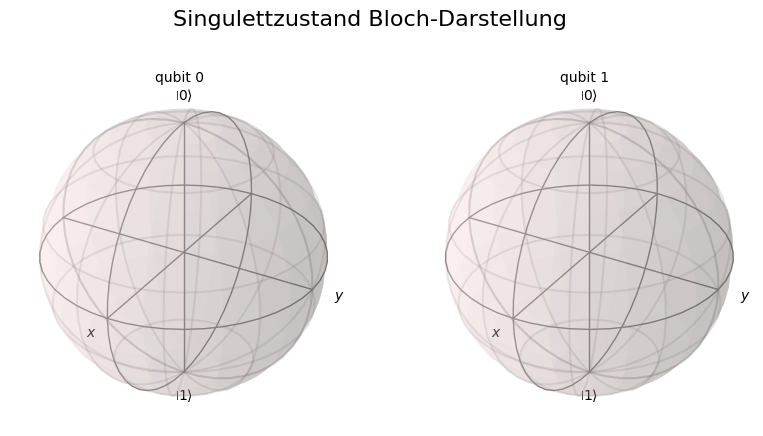

In [5]:
psi_sv = psi_state.data
fig = plot_bloch_multivector(psi_sv, title="Singulettzustand Bloch-Darstellung")
fig.show()

<a id="chsh"></a>
## 5. Messungen in verschiedenen Basen & CHSH-Test

Um die nicht-lokalen Korrelationen nachzuweisen (bzw. Eavesdropping zu erkennen), misst man das Bell-Paar in unterschiedlichen Basen. Ein häufig genutztes Vorgehen ist der **CHSH-Test**. Dabei misst Alice in zwei Winkeln (meist 0° und 45°) und Bob in zwei anderen Winkeln (22.5° und -22.5°), was einer bekannten Wahl für maximalen Verstoß gegen lokale Realismus-Theorien (Bell-Ungleichung) entspricht.
Der CHSH-Parameter \(S\) wird aus den Erwartungswerten (Korrelationswerten) in vier Einstellungen A0-B0, A0-B1, A1-B0, A1-B1 berechnet:
\[
    S = E(A0,B0) - E(A0,B1) + E(A1,B0) + E(A1,B1).
\]
Liegt \(|S|\) > 2, ist die CHSH-Ungleichung verletzt.

### Beispiel: Z-Basis und X-Basis
Wir erstellen hier ein exemplarisches Messprogramm, das Qubit 0 in Z bzw. X misst und Qubit 1 in Z bzw. X, und schauen uns an, welche Korrelationen wir erhalten. (Für einen echten CHSH-Test wählt man meist Zwischendrehungen, z.B. 0°, 22.5°, 45°, etc.)

In [6]:
# Beispiel: Qubit 0 in Z, Qubit 1 in Z

qc_test_zz = create_singlet_circuit()
qc_test_zz.measure_all()

transpiled_zz = transpile(qc_test_zz, simulator)
job_zz = simulator.run(transpiled_zz, shots=1024)
result_zz = job_zz.result()
counts_zz = result_zz.get_counts()
print("Z-Z Messung:", counts_zz)
E_zz = correlation(counts_zz)
print("Korrelationswert E(Z,Z):", E_zz)

Z-Z Messung: {'01': 529, '10': 495}
Korrelationswert E(Z,Z): -1.0


In [7]:
# Beispiel: Qubit 0 in X messen, Qubit 1 in Z
# => Erfordert vor dem Measure(0) eine H-Operation, damit wir die X-Basis messen.

qc_test_xz = create_singlet_circuit()
qc_test_xz.h(0)  # X-Basis auf Qubit 0
qc_test_xz.measure_all()

transpiled_xz = transpile(qc_test_xz, simulator)
job_xz = simulator.run(transpiled_xz, shots=1024)
result_xz = job_xz.result()
counts_xz = result_xz.get_counts()
print("X-Z Messung:", counts_xz)
E_xz = correlation(counts_xz)
print("Korrelationswert E(X,Z):", E_xz)

X-Z Messung: {'01': 251, '00': 252, '11': 250, '10': 271}
Korrelationswert E(X,Z): -0.01953125


Analog kann man beliebige weitere Basen messen, indem man das jeweilige Qubit in die richtige Rotationslage bringt. Zum Beispiel:
- Z-Basis: Keine Vorrotation
- X-Basis: H vor dem Messen
- Y-Basis: S-Dagger (\(S^\dagger\)) gefolgt von H (oder eine einzelne Drehung) vor dem Messen
usw.

In einem vollständigen CHSH-Test würde man 4 Messkreise aufbauen, wobei jeweils die Winkel A0, A1, B0, B1 realisiert werden, und dann den Parameter \(S\) berechnen. Typischerweise liegt \(S\) (ideal) bei ca. 2.8 für einen maximalen Verstoß.


<a id="schluessel"></a>
## 6. E91-Schlüsselerzeugung (Kurzfassung)

1. Alice und Bob erhalten eine Menge verschränkter Paare im Zustand \(|\psi^-\rangle\).
2. Alice misst zufällig in Basen A0 oder A1, Bob misst zufällig in Basen B0 oder B1 (siehe CHSH-Wahl). Sie notieren die Ergebnisse.
3. Sie vergleichen (einen Teil davon) öffentlich die gewählten Basen und checken die Korrelationen (CHSH). Wenn \(|S| > 2\) im statistischen Rahmen, ist das System sicher.
4. Für die gleichen Basen extrahieren sie die Bit-Werte, die identisch sein sollten.
5. Eine Fehlerkorrektur und Privatsphärenamplifikation kann daraufhin angewendet werden.
6. Fertig ist der geheime (nicht-lokal geteilte) Schlüssel!

In diesem Notebook haben wir die Kernideen illustriert. Für einen vollständigen QKD-Workflow (mit allen Protokollschritten) bräuchte man natürlich noch mehr Infrastruktur, z.B. klassische Kommunikation, Abgleich der Basen, Error Correction etc.

<a id="fazit"></a>
## 7. Fazit zum E91
- Wir haben das E91-Prinzip mithilfe von **Qiskit** simuliert:
  1. **Singulett-Zustand** erzeugt
  2. **Messungen** in unterschiedlichen Basen
  3. **CHSH-Parameter** berechnet
  4. **Bloch-Kugel**-Darstellungen zur Visualisierung gezeigt.
- Das E91-Protokoll demonstriert, wie **Verschränkung** und die **Verletzung lokaler Realismus-Ungleichungen** für sicheren Schlüsselaustausch genutzt werden können.
- In einer realen QKD-Anwendung (ob E91 oder BB84) kommen noch weitere Protokollschichten hinzu: **Fehlerkorrektur** und **Privacy Amplification**.

**Weiterführende Ideen:**
- Man kann die Winkel verallgemeinern, z.B. Messungen bei 0°, 45°, 22.5°, -22.5°.
- Den **CHSH-Parameter** vollständig implementieren, indem man 4 Messkreise ausführt und am Ende \(S\) berechnet.
- Visualization Tools nutzen, um Bobs und Alice' Messverteilungen/Histogramme zu zeigen.
- Noch **Noise** oder **Qubit-Fehler** einfügen (z.B. über Qiskit Noise Models), um zu sehen, wie stark das QKD-System belastet wird.



**Literatur zum Thema:**
1. Artur K. Ekert (1991). \"Quantum Cryptography Based on Bell’s Theorem.\" Physical Review Letters 67, 661
2. Nielsen & Chuang (2010). *Quantum Computation and Quantum Information*.
3. [Qiskit Doku und Tutorials](https://qiskit.org/documentation/)